# Training an Ensemble of probabilistic MC dropouts

This tutorial shows the data preprocessing and model training process for the case of an ensemble of probabilistic MC dropouts.

Important note: The models are trained using `train` data and the hyperparameters should be fine-tuned using `dev_in`.

In [1]:
import json
import pandas as pd
import torch
print("Torch Version", torch.__version__)

Torch Version 1.12.0+cu102


In [2]:
from vpower.src.utils.auxiliary_functions import load_data_and_set_index, data_normalization
from vpower.src.utils.plot_utils import plot_learning_curve
from vpower.src.models.mc_dropout import *

# Directories to be used

This tutorial assumes that
* all data files are placed in a local directory named `datasets`.
* the trained models, their histories (learning evolution) and train statistics for data scaling are to be stored in a local directory named `baselines`.

In [3]:
data_dir = "datasets"
model_dir = "baselines"

# Load data

In [4]:
train_data = load_data_and_set_index(filepath=os.path.join(data_dir, "train.csv"), index_column_name="time_id")
dev_in_data = load_data_and_set_index(filepath=os.path.join(data_dir, "dev_in.csv"), index_column_name="time_id")

print("Train records: ", train_data.shape[0])
print("Dev in records: ", dev_in_data.shape[0])

Train records:  523190
Dev in records:  18108


# Data scaling

In [5]:
input_features = ["draft_aft_telegram",
                  "draft_fore_telegram",

                  "stw",
                  "diff_speed_overground",

                  "awind_vcomp_provider",
                  "awind_ucomp_provider",
                  "rcurrent_vcomp",
                  "rcurrent_ucomp",
                  "comb_wind_swell_wave_height",

                  "timeSinceDryDock",
                  ]

target = "power"

The data scaling is performed based on the statistics of the train set. These statistics are saved in the file `stats` in order to be used during inference.

In [6]:
means = train_data.mean()
stds = train_data.std()

store_path = os.path.join(model_dir, 'stats')
if not os.path.exists(store_path):
        os.makedirs(store_path)

with open(os.path.join(store_path, 'means.json'), 'w') as f:
    json.dump(means.to_dict(), f, indent=4)

with open(os.path.join(store_path, 'stds.json'), 'w') as f:
    json.dump(stds.to_dict(), f, indent=4)

Data scaling description:
* For the time feature `timeSinceDryDock` we perform a `zeromax` scaling using a global timesince maximum = 4324320 minutes. This global maximum corresponds to a time duration of about 8 years between two dry docking cleaning events.
* The rest input features and the target are `standardized` (Z-scaling).

This is the recommended scaling process for the available features. Though depending on the method a different approach may be required.

In [7]:
train_norm = data_normalization(data=train_data, means=means, stds=stds)
dev_in_norm = data_normalization(data=dev_in_data, means=means, stds=stds)

In [8]:
train_ds = VPowerDataset(data=train_norm,
                         input_features=input_features,
                         target=target)
val_ds = VPowerDataset(data=dev_in_norm,
                       input_features=input_features,
                       target=target)

In [9]:
train_ds.norm_df.describe()

,awind_ucomp_provider,awind_vcomp_provider,comb_wind_swell_wave_height,diff_speed_overground,draft_aft_telegram,draft_fore_telegram,power,rcurrent_ucomp,rcurrent_vcomp,stw,timeSinceDryDock
count,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,5.231900e+05,523190.000000
mean,-1.508031e-16,-2.503244e-16,1.373308e-16,-2.585817e-17,1.964351e-15,1.043018e-17,1.894817e-16,-6.518865e-18,-4.345910e-18,1.324633e-15,0.226110
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.105390
min,-1.609081e+00,-3.310021e+00,-2.232109e+00,-8.232534e+00,-3.446784e+00,-3.433145e+00,-2.426341e+00,-5.882673e+00,-4.390627e+00,-4.405004e+00,0.002492
25%,-8.116068e-01,-7.564000e-01,-6.934100e-01,-6.196748e-01,-7.911742e-01,-7.115869e-01,-8.845777e-01,-4.522424e-01,-4.175400e-01,-7.257049e-01,0.154468
50%,-2.453545e-01,-1.782838e-02,-1.144700e-01,-1.413945e-03,2.027145e-01,1.915621e-01,1.926598e-01,-1.786759e-02,1.458298e-02,3.610918e-01,0.239873
75%,6.358525e-01,7.451101e-01,5.606564e-01,6.174625e-01,7.546046e-01,7.928354e-01,7.263591e-01,4.341876e-01,4.191766e-01,6.765600e-01,0.314985
max,3.124058e+00,2.792529e+00,4.615205e+00,8.767026e+00,1.991983e+00,2.053773e+00,2.944730e+00,5.925018e+00,4.435618e+00,2.322942e+00,0.401345


In [10]:
val_ds.norm_df.describe()

,awind_ucomp_provider,awind_vcomp_provider,comb_wind_swell_wave_height,diff_speed_overground,draft_aft_telegram,draft_fore_telegram,power,rcurrent_ucomp,rcurrent_vcomp,stw,timeSinceDryDock
count,18108.000000,18108.000000,18108.000000,18108.000000,18108.000000,18108.000000,18108.000000,18108.000000,18108.000000,18108.000000,18108.000000
mean,-0.010589,-0.010394,0.000170,-0.004532,-0.018445,-0.016511,-0.001157,-0.005270,0.017736,0.001897,0.225050
std,1.000879,1.003023,1.004720,1.008515,1.005792,1.006028,1.000186,1.017572,1.012673,1.007507,0.105497
min,-1.403206,-2.780314,-2.097898,-7.682830,-3.282808,-3.318444,-2.385850,-5.718967,-4.376341,-4.175345,0.002507
25%,-0.825332,-0.776243,-0.699829,-0.632162,-0.821703,-0.748621,-0.878052,-0.461039,-0.406383,-0.717358,0.150995
50%,-0.266308,-0.027246,-0.106138,-0.000047,0.179452,0.177131,0.191470,-0.026397,0.016753,0.366198,0.239491
75%,0.618634,0.737364,0.563308,0.618065,0.748202,0.786455,0.725109,0.431936,0.431445,0.681011,0.314219
max,2.962750,2.707252,4.371051,7.816620,1.929073,1.893327,2.743653,5.728669,4.205173,2.252377,0.401342


# Model training

In [11]:
models_hs = {}

for i in range(1, 11):
    store_path = os.path.join(model_dir, f"member_{i}/")
    if not os.path.exists(store_path):
        os.makedirs(store_path)

    model = ProbMCdropoutDNN(input_size=len(input_features),
                             hidden_size_1=50,
                             hidden_size_2=20,
                             dropout=0.005)
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

    history = train(model=model,
                    train_dataset=train_ds,
                    val_dataset=val_ds,
                    optimizer=optimizer,
                    store_path=store_path,
                    batch_size=32,
                    n_epochs=200,
                    es_monitor="val_mae",
                    patience=4)
    models_hs[i] = history

    with open(os.path.join(store_path, f"history.json"), 'w') as jsonfile:
        json.dump(history, jsonfile)

Epoch 0/200
Average train loss: -0.2853951940674118
Average val loss: -0.5574995627817648
Val MSE: 0.04683192575830874
Val MAE: 0.16776102277131047
Saved to ../my_models/ens_mc_dropout_synthetic/member_1//best_model.pth
Epoch 1/200
Average train loss: -0.5135658929534598
Average val loss: -0.598960886008432
Val MSE: 0.042541675094363705
Val MAE: 0.15836924169699632
Saved to ../my_models/ens_mc_dropout_synthetic/member_1//best_model.pth
Epoch 2/200
Average train loss: -0.5546077330181495
Average val loss: -0.6164311353222536
Val MSE: 0.04256175184135355
Val MAE: 0.15714147840313902
Saved to ../my_models/ens_mc_dropout_synthetic/member_1//best_model.pth
Epoch 3/200
Average train loss: -0.5760266051648771
Average val loss: -0.6213748013344017
Val MSE: 0.041445817830462285
Val MAE: 0.15590168504774993
Saved to ../my_models/ens_mc_dropout_synthetic/member_1//best_model.pth
Epoch 4/200
Average train loss: -0.5863833563164196
Average val loss: -0.6252325001557756
Val MSE: 0.04111270418854648


# Learning curves

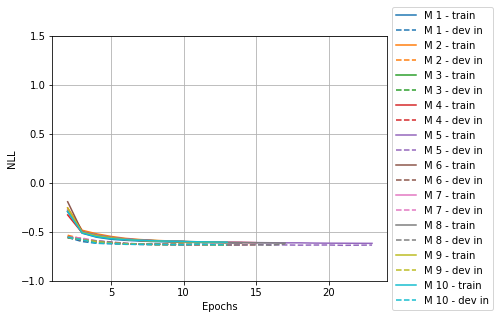

In [12]:
plot_learning_curve(history=models_hs,
                    metric="loss",
                    label="NLL",
                    ylims=(-1, 1.5))

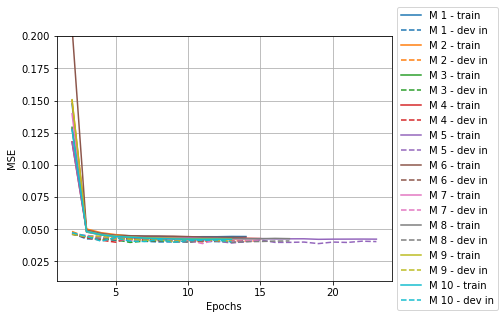

In [13]:
plot_learning_curve(history=models_hs,
                    metric="mse",
                    label="MSE",
                    ylims=(0.01, 0.2))

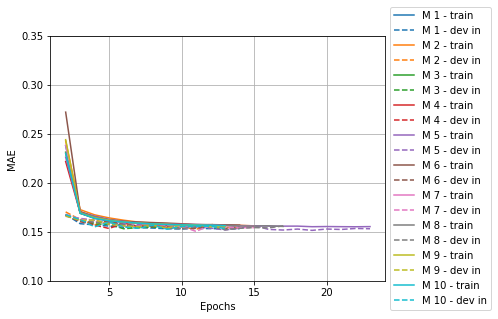

In [14]:
plot_learning_curve(history=models_hs,
                    metric="mae",
                    label="MAE",
                    ylims=(0.1, 0.35))